# Notebook for analysis of the CNN runs on the Ziram Dataset

# Runs analysis 

## Directly with mlflow

In [ ]:
# To list experiments:
mlflow experiments list

# To list runs in one experiment
mlflow runs list --experiment-id 1

# To have summary of an experiment with runs  in csv
mlflow experiments csv --experiment-id 1

# Manage experiments
mlflow experiments delete --experiment-id 0



## MlFlow client in python to retrieve datas

 This part is to recuperate the different experiments and recuperate the right id(s)

In [2]:
import mlflow

# mlflow.get_experiment_by_name('all_Ziramdataset_runs')
# exp_ls =  mlflow.cli.search_experiments(view_type=mlflow.entities.ViewType.ALL)

# for expe in exp_ls: 
#     print(expe.name, ': ', expe.experiment_id)

expe_ids = [ '1']
df_runs = mlflow.search_runs(experiment_ids=expe_ids)
print('Number of runs', len(df_runs))
df_class2 = df_runs[df_runs['tags.mlflow.runName'] == 'run_class2'].dropna(how='all', axis=1)


/hps/software/users/birney/fanny/cnn_venv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  """Entry point for launching an IPython kernel.


Finding best run in targeted experiment(s)

In [5]:
df_class2.filter(regex='metrics'), df_class2.filter(regex='params')
run_class2 = df_class2.loc[27, 'run_id']

best_run_df = df_runs.set_index('run_id').filter(regex='valAuroc').idxmax()
[val for val in df_runs.columns if 'metrics.' in val]
best_run_df
# print('Best val Auroc obtained for run id: ', best_run, 'Auroc = ', df_runs['metrics.valAuroc'].max())

Get best run info

In [8]:
import os
import pandas as pd
best_run = 'f164cdda2846446786bae52cdb59322a'
best_run_info = mlflow.get_run(run_id=str(best_run))
print(f'Detailled info of run id {best_run}:\n',best_run_info)
print('\nParams of the run', pd.DataFrame(best_run_info.data.params, index=['best run']).T.to_markdown())
# artifact_uri =best_run_info.info.artifact_uri.replace('flow-artifacts:', 'artifacts')
metrics_avail = best_run_info.data.metrics.keys()
metrics_avail
# os.listdir('mlartifacts/387340877257327242/96579a1d68fd4e6cb91050ea858aa920/artifacts/state_dict')
# state_dicts = os.listdir(os.path.join( artifact_uri, 'state_dict'))
# print('\nState_dict paths: ', state_dicts)


Detailled info of run id f164cdda2846446786bae52cdb59322a:
 <Run: data=<RunData: metrics={'randomAuroc_0': 0.5052553415298462,
 'randomAuroc_1': 0.46879634261131287,
 'randomAuroc_2': 0.49574771523475647,
 'randomAuroc_3': 0.4953594505786896,
 'randomAuroc_4': 0.5812629461288452,
 'trainAcc': 0.81,
 'trainAuroc_0': 0.9986337423324585,
 'trainAuroc_1': 0.9580246210098267,
 'trainAuroc_2': 0.9183050990104675,
 'trainAuroc_3': 0.9221351742744446,
 'trainAuroc_4': 0.9640190601348877,
 'trainLoss': 0.48870600269813286,
 'valAcc': 0.5231788079470199,
 'valAuroc_0': 0.9890180826187134,
 'valAuroc_1': 0.8205128312110901,
 'valAuroc_2': 0.7052006125450134,
 'valAuroc_3': 0.7031171321868896,
 'valAuroc_4': 0.813025176525116,
 'valLoss': 1.3131218612194062}, params={'BATCH_SIZE': '16',
 'EPOCHS': '50',
 'IMAGE_SIZE': '256',
 'LABEL': 'score',
 'LR': '0.001',
 'NUM_CLASS': '5',
 'PRED_BATCH_SIZE': '16'}, tags={'mlflow.runName': 'run_class5',
 'mlflow.source.git.commit': '83547d1fd7304ced72d131ffd7

dict_keys(['randomAuroc_2', 'randomAuroc_4', 'trainAuroc_4', 'valAuroc_0', 'trainAuroc_1', 'trainAuroc_3', 'valAuroc_1', 'trainAcc', 'valAuroc_2', 'trainAuroc_2', 'trainAuroc_0', 'valAcc', 'valAuroc_3', 'valAuroc_4', 'trainLoss', 'randomAuroc_3', 'randomAuroc_0', 'valLoss', 'randomAuroc_1'])

Recuperation of the metric history

In [4]:
client = mlflow.tracking.MlflowClient()
df_metric = pd.DataFrame()

for metric in list(metrics_avail):
    metric_info = client.get_metric_history(best_run, key=metric)
    df_metric[metric] = pd.DataFrame([{'step': x.step, metric: x.value } for x in metric_info]).set_index('step')[metric]
    
melt = df_metric.reset_index().melt(id_vars='step')
melt['variable'].unique()
melt['set'] =  melt['variable'].replace(regex={'.*' + val[:-3] + '.*' : val for val in ['training', 'valid ', 'random   ']})
melt['metric'] = melt[['variable']].replace(regex={'.*' + val + '.*' : val for val in ['Auroc', 'Loss', 'Acc']})
melt['class'] = melt['variable'].str.split('_', expand=True)[1]
melt

Plotting

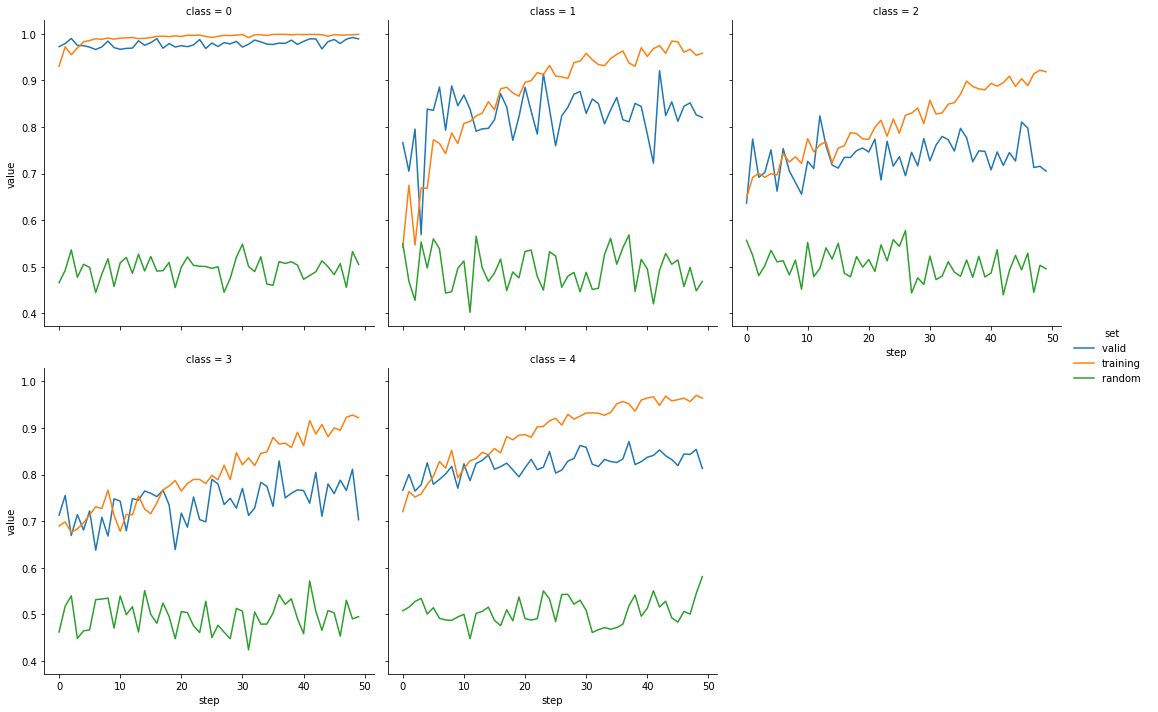

In [34]:
import seaborn as sns

sns.relplot(data=melt[melt['metric'] == 'Auroc'].sort_values('class'), x='step', y='value', hue='set', kind='line', col='class', col_wrap=3)

Plotting

<AxesSubplot: xlabel='step', ylabel='valAuroc'>

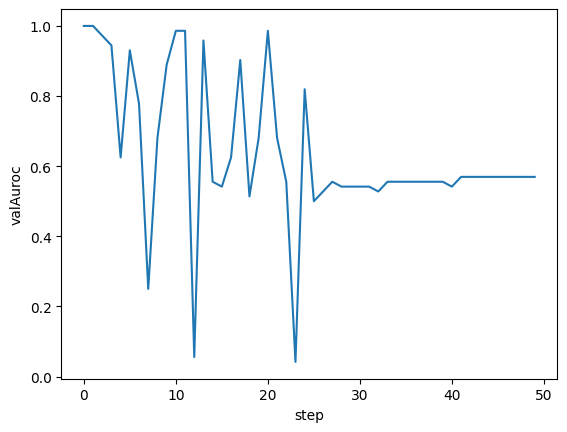

In [37]:
import seaborn as sns
sns.lineplot(df_auroc, x='step', y='valAuroc')

# Logits and regression analysis

([<matplotlib.axis.YTick at 0x7f1767248b70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

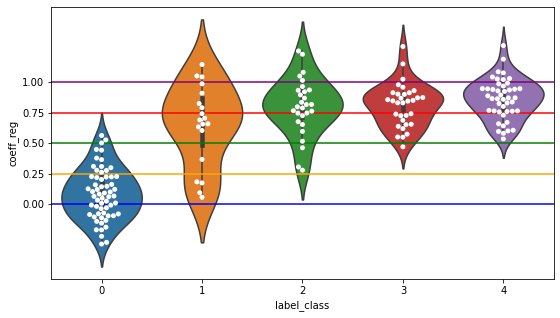

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

df_res = pd.read_csv('/homes/fanny/research/medaka/ziram_analysis/output/output_5classs/results_test.csv')

df_res.head()
df_res.drop('Unnamed: 0', axis=1, inplace=True)

fig, ax =  plt.subplots(figsize=(9,5))
ax = sns.violinplot(data=df_res, x='label_class', y='coeff_reg', hue='label_reg',dodge=False, legend=False)
ax = sns.swarmplot(data=df_res, x='label_class', y='coeff_reg', color='white')
ax.get_legend().set_visible(False)
# ax.grid(axis='y')
plt.axhline(y=0, color='blue')
plt.axhline(y=0.25, color='orange')
plt.axhline(y=0.5, color='green')
plt.axhline(y=0.75, color='red')
plt.axhline(y=1, color='purple')
plt.yticks([0, 0.25, 0.5, 0.75, 1])

|   label_class |         0 |         1 |         2 |         3 |         4 |
|--------------:|----------:|----------:|----------:|----------:|----------:|
|             0 | 0.916667  | 0         | 0.0666667 | 0         | 0.0166667 |
|             1 | 0.157895  | 0.157895  | 0.0526316 | 0         | 0.631579  |
|             2 | 0.0714286 | 0.0714286 | 0.214286  | 0         | 0.642857  |
|             3 | 0         | 0.0625    | 0.21875   | 0.09375   | 0.625     |
|             4 | 0         | 0         | 0.266667  | 0.0444444 | 0.688889  |
|   label_class |   0 |   1 |   2 |   3 |   4 |
|--------------:|----:|----:|----:|----:|----:|
|             0 |  55 |   0 |   4 |   0 |   1 |
|             1 |   3 |   3 |   1 |   0 |  12 |
|             2 |   2 |   2 |   6 |   0 |  18 |
|             3 |   0 |   2 |   7 |   3 |  20 |
|             4 |   0 |   0 |  12 |   2 |  31 |
|   label_class |   False |   True |
|--------------:|--------:|-------:|
|             0 |       5 |     55 |
|      

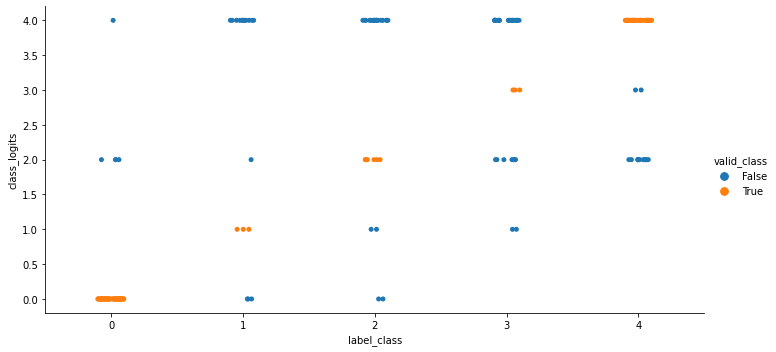

In [4]:
df_res.set_index('img_path', inplace=True)
df_res.reset_index()
df_res['class_logits'] = df_res.reset_index().filter(regex='^(?!.*reg)').groupby(['img_path', 'label_class']).idxmax(axis='columns').reset_index().set_index('img_path')[0].str.replace('logits_', '')


df_res['class_logits'] = df_res['class_logits'].astype(int)
df_res['valid_class'] = df_res['label_class'].astype(int) == df_res['class_logits'].astype(int)

sns.catplot(data=df_res, x='label_class', y='class_logits', hue='valid_class', kind='strip', aspect=2)

print(df_res.groupby('label_class')['class_logits'].value_counts(normalize=True).unstack().fillna(0).to_markdown())
print(df_res.groupby('label_class')['class_logits'].value_counts().unstack().fillna(0).to_markdown())
print(df_res.groupby('label_class')['valid_class'].value_counts().unstack().fillna(0).to_markdown())

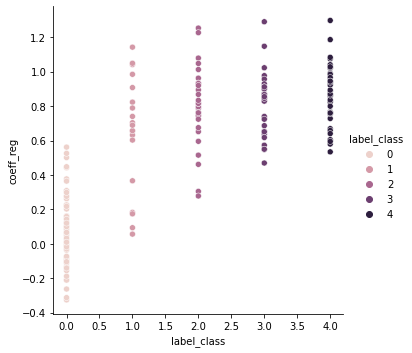

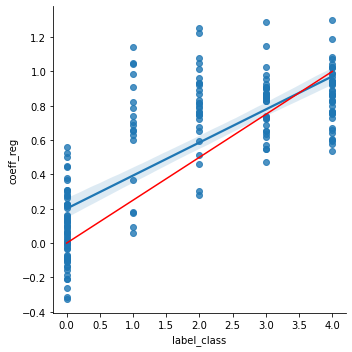

In [10]:
sns.relplot(data=df_res, x='label_class', y='coeff_reg', hue='label_class')
plt.show()

sns.lmplot(data=df_res, x='label_class', y='coeff_reg')
plt.plot([0, 4], [0,1], 'red')
plt.show()


> ---
>
> **Note**
>
> NB: For the logits analysis, perform a binary classification and then with the logits associates with severity
>
> ---



In [64]:
pd.read_csv()

,label_class,label_reg,coeff_reg,logits_0,logits_1,logits_2,logits_3,logits_4,class_logits
img_path,,,,,,,,,
/homes/fanny/research/medaka/ziram_analysis/dataset_ziram_CO4/test_set/WE00049---E001--PO01--LO001--CO4--SL001--PX32500--PW0100--IN6000--TM280--X014463--Y047049--Z211075--T2853904037.png,0,0.00,-0.131958,3.922391,-0.429810,-0.489217,-3.479553,-3.467457,0
/homes/fanny/research/medaka/ziram_analysis/dataset_ziram_CO4/test_set/WE00077---G005--PO01--LO001--CO4--SL001--PX32500--PW0100--IN6000--TM284--X050499--Y064992--Z210453--T2864570056.png,3,0.75,0.686555,-2.621734,-0.458305,0.352652,0.002930,1.578016,4
/homes/fanny/research/medaka/ziram_analysis/dataset_ziram_CO4/test_set/WE00021---B004--PO01--LO001--CO4--SL001--PX32500--PW0100--IN6000--TM284--X041490--Y020134--Z214177--T2859965607.png,4,1.00,0.763134,-2.385634,-0.312198,0.899033,-1.102785,1.732536,4
/homes/fanny/research/medaka/ziram_analysis/dataset_ziram_CO4/test_set/WE00009---A009--PO01--LO001--CO4--SL001--PX32500--PW0100--IN6000--TM250--X086535--Y011163--Z216870--T2936794154.png,3,0.75,0.976933,-3.842399,-1.340908,1.611302,0.591890,1.533534,2
/homes/fanny/research/medaka/ziram_analysis/dataset_ziram_CO4/test_set/WE00015---B010--PO01--LO001--CO4--SL001--PX32500--PW0100--IN6000--TM283--X095544--Y020134--Z211177--T2859478719.png,2,0.50,0.787045,-3.037503,-0.899213,1.048414,0.275351,1.351430,4


In [ ]:
# Add the genetic info 


# Encoding analysis

In [ ]:
# Add the genetic info 

